# **Module 10: Introduction to Neural Networks**
Artificial Neural Networks are modeled on the human brain. They are true learning networks in that they self-optimize with a learning function that is designed to reduce the error of each processing cycle. This is why Neural Networks work well with large datasets and unstructured data.

At the end of this module, you will be able to:
* Describe how a simple Neural Network works
* Identify the summation and the activation functions
* Take appropriate preprocessing steps for Neural Networks
* Build a simple Neural Network

Let's get started!


# **What is a Neural Network?**
Neural networks are modeled after the human brain. As the name indicates, Neural Networks consist of neurons, where the data processing happens, and dendrites and axons that make up the pathways between neurons. 

<div>
<center>
<img src="https://raw.githubusercontent.com/shstreuber/Data-Mining/master/images/1200px-Neural_network_example.svg.png" width="200">
</div>

The data enter the Neural Network through the **INPUT LAYER** (green) and the classification results are found in the **OUTPUT LAYER** (purple). As the data makes its way through the network, its value is determined by weights. These weights are adjusted by an algorithm called a perceptron, whose goal is to minimize error values. That happens int he **HIDDEN LAYER** (teal).

Each neuron in the hidden layer contains essentially two functions:
1. The summary function, which aggregates input data and passes its output on to the 
2. Activation function, which applies a previously defined algorithm to the data it has received from the summary function. 

Here is a close-up (from [an awesome article on Towards Data Science](https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24) that you should read!) of what happens inside one of the teal dots above. The **SUMMATION FUNCTION** is blue and the **ACTIVATION FUNCTION** is purple. Note that the output is red:

<div>
<center>
<img src="https://raw.githubusercontent.com/shstreuber/Data-Mining/master/images/neuralnetwork.png" width="600">
</div>

And now take a look at the instructor video explaining this in detail and demonstrating how this works mathematically:




In [45]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/NyAcHViPlCg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

#**0. Preparation and Setup**

As before, we are following the basic classification steps:

1. **Exploratory Data Analysis (EDA)** to see how the data is distributed and to determine what the class attribute in the dataset should be. This will be the attribute you'll predict later on
2. **Preprocess the data** (remove n/a, transform data types as needed, deal with missing data) --> here is where we will need to take a few additional steps to **configure our data for the Neural Network**
3. **Split the data** into a training set and a test set
4. **Build the model** based on the training set
5. **Test the model** on the test set
6. **Determine the quality of the model** with the help of a Confusion Matrix and a Classification Report.

As with our previous problems, we will use the insurance dataset again.

In [46]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns # for visualization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

#Reading in the data as insurance dataframe
insurance = pd.read_csv("https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/insurance_with_categories.csv")

#Verifying that we can see the data
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# **1. Exploratory Data Analysis (EDA)**
As before, we have the option to either do this in a code cell, or to import the HTML-based pandas_profile package.

##Your Turn
Remember the [pandas_profiling package](https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/) that you encountered in the module on kNN and Naive Bayes? Install it below to complete this week's EDA section:

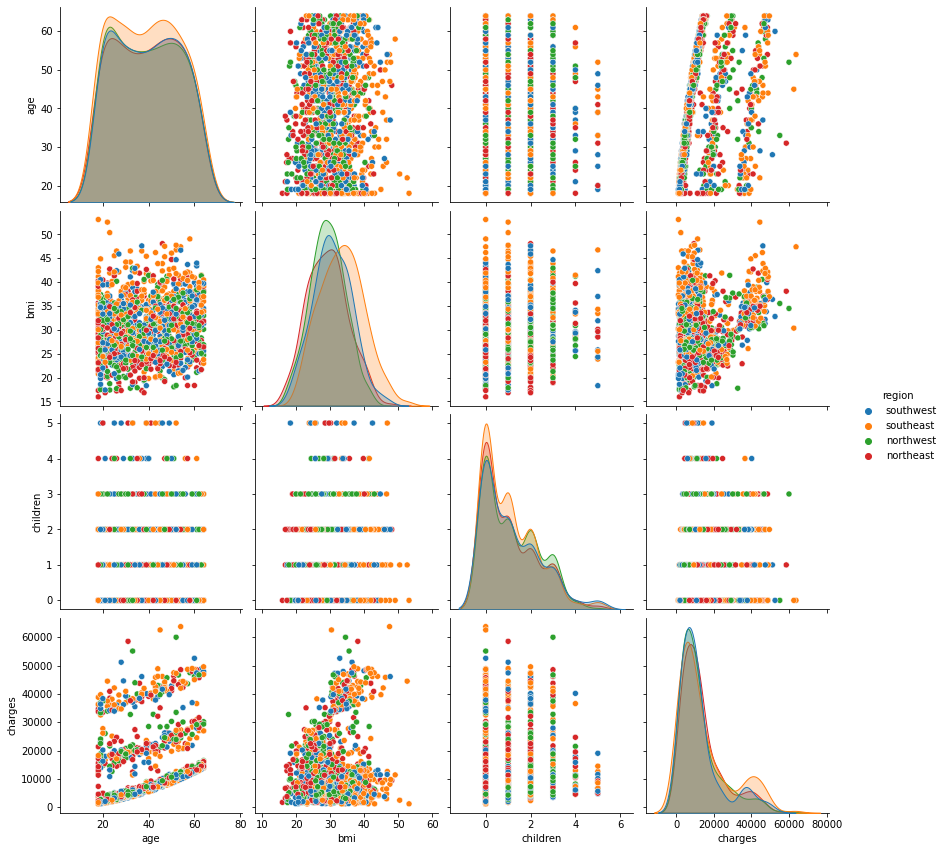

In [47]:
# Visualizing the data with a pairplot because why not?
# Let's investigate what kinds of relationships exist between the variables.

sns.pairplot(insurance,hue="region", height=3, diag_kind="kde")

We can see that the dataset is somewhat structured with linear relationships among age and charges. However, we don't see a clear distribution for region--and we remember that the results from our Random Forest analysis weren't too convincing at about 37% accuracy. Let's see if a Neural Network gives us a better understanding of how the numeric predictors in the dataset can help us determine the region attribute.

# **2. Preprocessing**

##**2.1 Reducing the Data**
You have done this before. Build an insurance_nn dataset consisting of age, bmi, children, charges, and--again--region as the class attribute. 

##**2.2 Preparing the Data for use with a Neural Network**
In this section, you will see that preparing data to work with a Neural Network requires a bit more preprocessing than what you may be used to from previous algorithms.

### 2.2.1 Encoding
Our Neural Network code will require numeric labels in the output layer. It will not work with categorical variables. This is why we will need [LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to transform the non-numerical labels in 'region' (as long as they are hashable and comparable) to numerical labels.

In [48]:
# Replace southwest with 0, southeast with 1, northwest with 2, and northeast with 3 
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
insurance_nn["region"] = labelencoder.fit_transform(insurance_nn["region"])
region = pd.DataFrame({'region': ['southwest', 'southeast', 'northwest', 'northeast']})
insurance_nn.head()

,age,bmi,children,charges,region,region_0,region_1,region_2,region_3,region_0,region_1,region_2,region_3
0,19,27.900,0,16884.92400,3,0,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,2,0,0,1,0,0,0,1,0
2,28,33.000,3,4449.46200,2,0,0,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0,0,1,0,0


**NICE!**

**UH, WAIT!:** LabelEncoder introduced a new problem: The numbers in 'region' look like ordinal relationships--but southeast(1) is not higher than southwest(0) and southeast(1) is not smaller than northwest(2). 

That's why, in our case, LabelEncoder will not work out, and we need instead a four-dimensional vector. With a four-dimensional vector, our Neural Network can then assign presence (=1) or absence (=0) to each of our four labels. Thus, southwest would be [1,0,0,0], southeast would be [0,1,0,0], northwest would be [0,0,1,0], and northeast [0,0,0,1]. If you google around, you'll find that that's what [Onehotencorder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) does. 

**BUT** 

OneHotEncoder doesn't work with strings--and that's what we have in our 'region' attribute: Categorical data in words, i.e. strings. So, there is a third (and, I promise, final!) option to preprocess out data: We will use [get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html). Getdummies converts string columns into one-hot representation (also known here as a sparse matrix because it has a few 1s and many 0s). That's what we want!



In [49]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df
insurance_nn = create_dummies(insurance_nn,"region")

insurance_nn.head()

,age,bmi,children,charges,region,region_0,region_1,region_2,region_3,region_0,region_1,region_2,region_3,region_0,region_1,region_2,region_3
0,19,27.900,0,16884.92400,3,0,0,0,1,0,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,2,0,0,1,0,0,0,1,0,0,0,1,0
2,28,33.000,3,4449.46200,2,0,0,1,0,0,0,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0,0,1,0,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0,0,1,0,0,0,1,0,0


And here we are! As you can see above, the region attribute--our class--is no longer just one column (although we left 'region' in the dataframe to prove the point); it is now 4 columns, indexed from 0 to 3. These are the four labels in the output layer. Now the Neural Network just needs to check which of the "region bits" is switched on, and the data tuple can be dropped under that respective label. 

But we are not yet done with preprocessing.

### 2.2.2 Standardizing the Data ##
Well, not only do Neural Networks not like string-type labels in the output layer; they also don't like non-standardized input attributes (aka features). That's because the Summation and Activation functions treat the values from each input attribute the same. Hence, these values need to fall into the same scale.

That is why need need to scale our feature values to a range between -1 and 1. 

For this, we will scale our data with [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). This helps us to speed up our algorithm (gradient descent) and have a more accurate classifier.

In [50]:
# Features before mean normalization
unscaled_features = insurance_nn[['age','bmi','children','charges']]

# Mean Normalization to have a faster classifier 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Calculate μ & σ(fit) and apply the transformation(transform)
unscaled_features_array = sc.fit_transform(unscaled_features.values)

# Assign the scaled data to a DataFrame & use the index and columns arguments to keep your original indices and column names:
scaled_features = pd.DataFrame(unscaled_features_array, index=unscaled_features.index, columns=unscaled_features.columns)

scaled_features.head()

,age,bmi,children,charges
0,-1.438764,-0.453320,-0.908614,0.298584
1,-1.509965,0.509621,-0.078767,-0.953689
2,-0.797954,0.383307,1.580926,-0.728675
3,-0.441948,-1.305531,-0.908614,0.719843
4,-0.513149,-0.292556,-0.908614,-0.776802


Alright! Now that we are done with preprocessing, we can move on to the next step.

#**3. Splitting the data into Training and Test Set**


In [51]:
from sklearn.model_selection import train_test_split
X = scaled_features
y = insurance_nn['region']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#**4. Determine Neural Network Architecture, then Build and Train the Model**

When we build the Neural Network architecture, we have to configure the following settings:
* the nummber of nodes in each layer
* the number of layers
* the way in which nodes are connected (feedforward, no loops between the units). 

The number of nodes in the input and output layers is determined by the dimensionality of the problem: We have 4 input units (age, bmi, children, charges) and 4 output units ('southwest', 'southeast', 'northwest', 'northeast'). 

However, determining the number of hidden nodes is not as easy. Typically, 10 nodes in the hidden layer tends to work better when the first hidden layer is larger than the input layer.

We will use the [Multilayer Perceptron classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) for this. The most salient parameters are:

* hidden_layer_sizes tuple, length = n_layers - 2, default=(100,)
The ith element represents the number of neurons in the ith hidden layer.

* activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
Activation function for the hidden layer.

  * ‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x

  * ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).

  * ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x).

  * ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)

* solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
The solver for weight optimization. We will talk about this more when we talk about Gradient Descent

  * ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.

  * ‘sgd’ refers to stochastic gradient descent.

  * ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba

* batch_size int, default=’auto’
Size of minibatches for stochastic optimizers. If the solver is ‘lbfgs’, the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples)

* max_iter int, default=200
Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

* verbose bool, default=False
Whether to print progress messages to stdout.

* validation_fraction float, default=0.1
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True

This sounds like a lot. As you will see below, however, building the model is pretty anticlimactic.


In [52]:
from sklearn.neural_network import MLPClassifier

# Initializing the multilayer perceptron
# running this with all the default settings, including a hidden_layer_sizes setting of 100 adn 200 maximum iterations. 
# Verbose is on so we can see how this runs.

mlp1 = MLPClassifier(verbose=1) # We are running this in verbose mode so we can see the output of each iteration.

Now that we have built the model (with all default settings, so we will look at 200 iterations), we will train the model on our training set. 

Since this will run in verbose mode, you will be able to see the self-optimization as it happens. Watch for the loss function (i.e. the error rate) becoming smaller with each iteration.

In [53]:
# As this runs in verbose mode, note how the loss function steps down with every single iteration!

mlp1.fit(X_train, y_train)

Iteration 1, loss = 1.38735605
Iteration 2, loss = 1.37060409
Iteration 3, loss = 1.36087091
Iteration 4, loss = 1.35437587
Iteration 5, loss = 1.35037955
Iteration 6, loss = 1.34733878
Iteration 7, loss = 1.34489464
Iteration 8, loss = 1.34266297
Iteration 9, loss = 1.34083392
Iteration 10, loss = 1.33915505
Iteration 11, loss = 1.33804148
Iteration 12, loss = 1.33682234
Iteration 13, loss = 1.33588784
Iteration 14, loss = 1.33490988
Iteration 15, loss = 1.33386824
Iteration 16, loss = 1.33287728
Iteration 17, loss = 1.33210788
Iteration 18, loss = 1.33157000
Iteration 19, loss = 1.33070941
Iteration 20, loss = 1.32991019
Iteration 21, loss = 1.32914162
Iteration 22, loss = 1.32846504
Iteration 23, loss = 1.32772228
Iteration 24, loss = 1.32734348
Iteration 25, loss = 1.32670705
Iteration 26, loss = 1.32633548
Iteration 27, loss = 1.32569144
Iteration 28, loss = 1.32493738
Iteration 29, loss = 1.32450532
Iteration 30, loss = 1.32413741
Iteration 31, loss = 1.32347420
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

The output here shows how the function is configured: 
* Relu: The units in the hidden layer apply the activation function to induce a sense of non-linearity in the network. Relu tells us how close these z are to 1 (1= we discover a pattern, namely a feature combination that leads to this output). In this way, we are discovering patterns from examining input-output examples. Without an activation function, NN would just be a linear regression function.
* 1 Epoch = 1 pass over the entire dataset
* Batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you’ll need.

#**5. Test the Model**
The moment of truth! What is the accuracy score here?


In [54]:
# Score takes a feature matrix X_test and the expected target values y_test. 
# Predictions for X_test are compared with y_test

print (mlp1.score(X_test,y_test))

0.31716417910447764


Um. Well. Maybe that wasn't such a great idea.

#**. Evaluate the Quality**
You know the drill! First, we set up the Confusion Matrix, then the Classification Report.

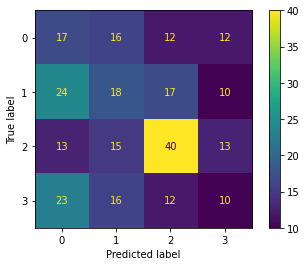

In [55]:
# Set up Confusion Matrix

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp1, X_test, y_test)

##Your Turn
What do you think of our model, given this Confusion Matrix? Is it better or worse than our Random Forest? How does it compare with our k Nearest Neighbor or our Naive Bayes output?  Record your answer below.

In [56]:
# Now, let's see what the predictions look like
y_pred = mlp1.predict(X_test)
print("Test set predictions: \n {}".format(y_pred))

Test set predictions: 
 [0 3 1 0 3 2 0 2 3 1 0 3 1 2 2 2 2 2 1 0 0 3 0 2 1 0 0 1 1 0 0 1 2 0 1 2 1
 3 1 2 0 2 3 0 2 1 1 0 1 2 0 2 2 0 3 1 3 2 0 3 1 2 1 0 0 1 0 1 1 2 2 3 3 3
 2 3 3 0 1 0 2 1 1 2 2 2 3 1 1 3 2 1 1 1 2 3 1 2 0 0 1 0 2 2 0 2 3 0 0 0 2
 2 1 3 1 2 1 1 1 1 1 3 2 2 0 3 2 1 0 2 3 3 2 2 2 2 2 0 2 3 3 3 2 2 0 1 1 0
 3 1 2 0 2 3 2 2 1 1 3 3 1 1 1 0 1 3 2 2 3 0 0 1 2 1 0 0 0 2 0 0 1 0 0 2 0
 2 1 0 2 0 2 0 0 3 2 3 0 1 0 3 3 0 2 0 0 0 3 0 2 0 0 1 2 0 0 0 1 1 0 2 2 2
 2 2 2 3 0 0 1 3 2 0 1 3 0 2 1 2 2 2 0 2 2 1 0 2 1 1 2 3 0 3 0 0 2 1 1 2 0
 3 1 0 0 2 0 1 2 3]


In [60]:
from sklearn import metrics
from sklearn.metrics import classification_report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.30      0.25        57
           1       0.28      0.26      0.27        69
           2       0.49      0.49      0.49        81
           3       0.22      0.16      0.19        61

    accuracy                           0.32       268
   macro avg       0.30      0.30      0.30       268
weighted avg       0.32      0.32      0.32       268



# **Gradient Descent**

Gradient Descent is a way to optimize how quickly the weights are adjusted in the Neural Network, i.e. how often the Feed Forward-Backpropagation loop has to run to optimize the error aka loss function. To learn more about Gradient Descent, read through [this explanation](https://www.kdnuggets.com/2017/04/simple-understand-gradient-descent-algorithm.html) and watch this awesome video below:



In [61]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/sDv4f4s2SB8" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

Now that you know all about gradient descent, we will re-run the MLP Classifier with the Stochastic Gradient Descent optimizer configured. We will specifically pay attention to the parameters shown.

* Stochastic Gradient Descent (SGD) optimizer/solver: updates weights values that minimize the loss function in batches. As the name says, SGD uses the gradient of the loss function. Use parameter solver = sgd.

* learning_rate_init=0.01: This parameter controls the step-size in updating the weights, and here is constant. Its value shouldn’t be too large( fail to converge) neither too small (too slow).

* max_iter=500 : maximum number of epochs (=how many times each data point will be used until solver convergence).

In [62]:
mlp2 = MLPClassifier(hidden_layer_sizes=10,solver='sgd',learning_rate_init= 0.01, max_iter=500, verbose = 1)

## YOUR TURN

1. Fit the test data to mlp2, then produce a confusion matrix and a correlation report, and see if changing the parameters has made any difference.
2. Produce an mlp3 model in which you change the solver and the learning rate  however you want (leave verbose on, though). This will change the Gradient Descent. What difference has this made?

#SOLUTIONS
To help you get unstuck:

In [ ]:
# This is the solution for task 2 above. 
insurance_nn = pd.DataFrame(insurance, columns = ['age', 'bmi', 'children','charges','region'])
insurance_nn.head()